In this notebook we show how to use the new deepymod code and phimal utilities to load data and perform data analysis:

In [92]:
import numpy as np
import pandas as pd
import torch

from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepModDynamic
from DeePyMoD_SBL.deepymod_torch.training import train_dynamic
from sklearn.linear_model import LassoLarsIC

from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta
from phimal_utilities.analysis import load_tensorboard

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Making data

In [38]:
x = np.linspace(-3, 4, 100)
t = np.linspace(0.5, 5.0, 50)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

Create a dataset by giving your solution to the object and its parameters (make sure they're named)

In [39]:
dataset = Dataset(BurgersDelta, v=0.1, A=1.0)

We can easily generate a solution given our grid:

In [40]:
u = dataset.generate_solution(x_grid, t_grid)

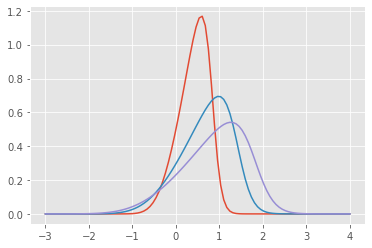

In [41]:
frame = 10
plt.plot(x, u[:, frame - 10])
plt.plot(x, u[:, frame])
plt.plot(x, u[:, frame + 10])

Or check if our solution is correct using the library:

In [42]:
theta = dataset.library(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1))
dt = dataset.time_deriv(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1))

np.linalg.lstsq(theta, dt, rcond=None)[0]

array([[ 5.14833357e-17],
       [-7.57342323e-16],
       [ 1.00000000e-01],
       [-2.41045248e-16],
       [-1.00000000e+00],
       [ 5.64327231e-17],
       [-1.38852417e-16],
       [ 2.08782838e-16],
       [ 1.34034494e-17]])

We can also automatically create input data for deepmod. To confirm we add noise, we use all samples (set n_samples=0 for all) and turn of randomization:

In [43]:
X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.1, random=False)

In [44]:
u_noisy = y_train.reshape(x_grid.shape).cpu().detach().numpy()

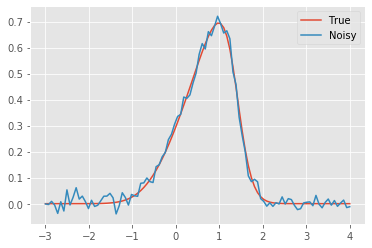

In [45]:
frame = 10
plt.plot(x, u[:, frame], label='True')
plt.plot(x, u_noisy[:, frame], label='Noisy')

plt.legend()

Now let's generate a real dataset:

In [46]:
X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=2000, noise=0.1, random=True)

# Running deepmod

Now we show how to use the new deepmod. We first define which sparsity estimator we want to use. All estimators from scikitlearn are fine. set fit_intercept to false as that term is in our model.

In [47]:
estimator = LassoLarsIC(fit_intercept=False)

Then we define the config and build the model as always:

In [48]:
config = {'n_in': 2, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}, 'sparsity_estimator': estimator}
model = DeepModDynamic(**config)


#In the future, I want to change the api so that we would do the following:
'''
function_approximator = network(n_in=2, hidden_dims=[30, 30, 30, 30, 30], n_out=1)
library = Library(function=library_1D_in, poly_order=2, deriv_order=2)
sparse_estimator = Estimator(fit_intercept=False)

model = DeepMoD(function_approximator, library, sparse_estimator)
'''
# main reason is not to get a massive config dictionary which is not very clear. This would also be super flexible.

'\nfunction_approximator = network(n_in=2, hidden_dims=[30, 30, 30, 30, 30], n_out=1)\nlibrary = Library(function=library_1D_in, poly_order=2, deriv_order=2)\nsparse_estimator = Estimator(fit_intercept=False)\n\nmodel = DeepMoD(function_approximator, library, sparse_estimator)\n'

Define the optimizer:

In [49]:
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

And train for 15k:. We start the sparsity update after 5000 iterations so we have a good estimate of the data and update it every 200 iterations after:

In [50]:
train_dynamic(model, X_train, y_train, optimizer, 15000, loss_func_args={'start_sparsity_update': 5000, 'sparsity_update_period': 200})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      15000    100.00%               0s   3.44e-04   3.41e-04   2.66e-06   0.00e+00 

We get the following coefficients from the sparsity model (which are biased by the l1):

In [51]:
model.sparsity_estimator.coef_

array([ 0.        , -0.00776358,  0.65028882,  0.        , -0.98327089,
        0.        ,  0.        ,  0.        ,  0.        ])

The unbiased coefficients we get from the network by:

In [52]:
model.constraints.coeff_vector

[tensor([[-0.0031],
         [ 0.0989],
         [-0.9996]], grad_fn=<MmBackward>)]

It has one extra term, but its super small. Thats an issue for next time. This is done with 10% noise.

# Analysing

To analyse more in depth, we can load the tensorboard file:

In [53]:
# right now works with file path, will change to experiment_ID 
df = load_tensorboard('runs/Apr22_16-06-14_4b6076e78386/')

In [54]:
df.head(5)

,Total_loss,MSE_0,Regression_0,L1_0,coeff_0_0,coeff_0_1,coeff_0_2,coeff_0_3,coeff_0_4,coeff_0_5,...,coeff_0_8,scaled_coeff_0_0,scaled_coeff_0_1,scaled_coeff_0_2,scaled_coeff_0_3,scaled_coeff_0_4,scaled_coeff_0_5,scaled_coeff_0_6,scaled_coeff_0_7,scaled_coeff_0_8
0,0.051412,0.051405,0.000007,0.000007,0.012150,-0.325502,-0.853040,-0.853617,11.300903,-7.467178,...,110.875488,0.857205,-0.397089,-0.692373,-1.903975,0.736789,-0.180344,1.055231,0.070499,0.209822
100,0.013880,0.013007,0.000874,0.000874,-0.016194,-0.187640,0.001426,0.086010,-0.824461,0.361347,...,-0.707848,-0.329426,-0.605109,0.004689,0.386760,-0.568317,0.370190,-0.225219,0.556316,-0.279357
200,0.006283,0.005862,0.000421,0.000421,0.009538,-0.232684,0.037852,0.233261,0.411873,-0.211583,...,-0.275103,0.182986,-0.945609,0.219352,1.061824,0.489359,-0.503140,-1.754082,-0.560536,-0.320851
300,0.003656,0.003487,0.000170,0.000170,0.012385,-0.105834,0.012952,-0.071539,-0.746077,0.346926,...,-0.680861,0.213806,-0.407004,0.091915,-0.272326,-0.954558,1.170330,-0.047470,0.460189,-1.240764
400,0.001758,0.001608,0.000150,0.000150,0.008800,-0.120296,0.024360,-0.004866,-0.542959,0.208395,...,-0.368399,0.106491,-0.367870,0.160300,-0.013724,-0.646523,0.754378,-0.301574,0.097489,-0.862853


All the keys are:

In [55]:
df.keys()

Index(['Total_loss', 'MSE_0', 'Regression_0', 'L1_0', 'coeff_0_0', 'coeff_0_1',
       'coeff_0_2', 'coeff_0_3', 'coeff_0_4', 'coeff_0_5', 'coeff_0_6',
       'coeff_0_7', 'coeff_0_8', 'scaled_coeff_0_0', 'scaled_coeff_0_1',
       'scaled_coeff_0_2', 'scaled_coeff_0_3', 'scaled_coeff_0_4',
       'scaled_coeff_0_5', 'scaled_coeff_0_6', 'scaled_coeff_0_7',
       'scaled_coeff_0_8'],
      dtype='object')

We plot the losses:

Text(0.5, 1.0, 'Regression')

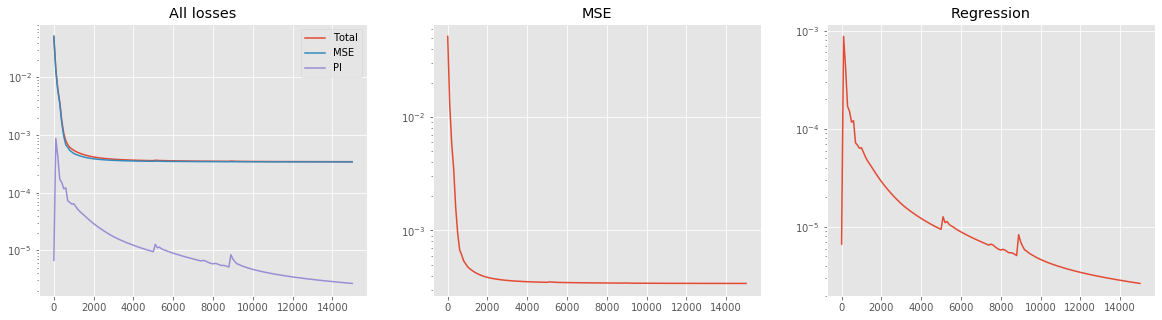

In [56]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.semilogy(df.index, df['Total_loss'], label='Total')
plt.semilogy(df.index, df['MSE_0'], label='MSE')
plt.semilogy(df.index, df['Regression_0'], label='PI')
plt.title('All losses')
plt.legend()

plt.subplot(132)
plt.semilogy(df.index, df['MSE_0'], label='MSE')
plt.title('MSE')

plt.subplot(133)
plt.semilogy(df.index, df['Regression_0'], label='PI')
plt.title('Regression')

Now let's look at the coefficients:

In [57]:
coeff_keys = [key for key in df.keys() if key[:5]=='coeff']
scaled_coeff_keys = [key for key in df.keys() if key[:6]=='scaled']

Text(0.5, 1.0, 'Coefficients')

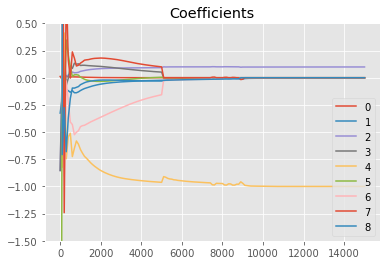

In [63]:
for key in coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-1.5, 0.5])
plt.title('Coefficients')

Text(0.5, 1.0, 'Scaled coefficients')

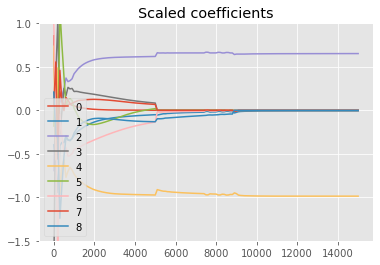

In [61]:
for key in scaled_coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-1.5, 1])
plt.title('Scaled coefficients')

So we do see a few kinks but not many and certainly with minimal effect. We can also check when terms in are the model:

In [104]:
in_model = []
for key in scaled_coeff_keys:
    in_model.append(df[key].to_numpy()[:, None])
in_model = np.concatenate(in_model, axis=1)
in_model[np.abs(in_model) > 0 ]= 1

Text(0.5, 1, 'Heatmap of coefficients in model')

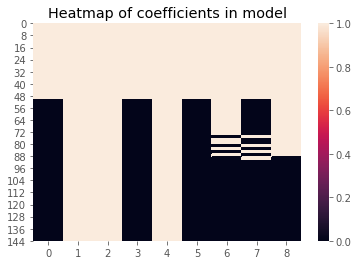

In [106]:
sns.heatmap(in_model)
plt.title('Heatmap of coefficients in model')